# House price prediction with Deep Learning 

In [1]:
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/adhiman/anaconda3/envs/python3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model

/Users/adhiman/anaconda3/envs/python3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load data

In [3]:
kc_data_org = pd.read_csv("data/kc_house_data.csv.zip")

In [4]:
kc_data_org['sale_yr'] = pd.to_numeric(kc_data_org.date.str.slice(0, 4))
kc_data_org['sale_month'] = pd.to_numeric(kc_data_org.date.str.slice(4, 6))
kc_data_org['sale_day'] = pd.to_numeric(kc_data_org.date.str.slice(6, 8))

kc_data = pd.DataFrame(kc_data_org, columns=[
        'sale_yr','sale_month','sale_day',
        'bedrooms','bathrooms','sqft_living','sqft_lot','floors',
        'condition','grade','sqft_above','sqft_basement','yr_built',
        'zipcode','lat','long','sqft_living15','sqft_lot15','price'])
label_col = 'price'

kc_data.head()

,sale_yr,sale_month,sale_day,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,2014,10,13,3,1.00,1180,5650,1.0,3,7,1180,0,1955,98178,47.5112,-122.257,1340,5650,221900.0
1,2014,12,9,3,2.25,2570,7242,2.0,3,7,2170,400,1951,98125,47.7210,-122.319,1690,7639,538000.0
2,2015,2,25,2,1.00,770,10000,1.0,3,6,770,0,1933,98028,47.7379,-122.233,2720,8062,180000.0
3,2014,12,9,4,3.00,1960,5000,1.0,5,7,1050,910,1965,98136,47.5208,-122.393,1360,5000,604000.0
4,2015,2,18,3,2.00,1680,8080,1.0,3,8,1680,0,1987,98074,47.6168,-122.045,1800,7503,510000.0


In [5]:
kc_data.describe()

,sale_yr,sale_month,sale_day,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,2.161300e+04
mean,2014.322954,6.574423,15.688197,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,3.409430,7.656873,1788.390691,291.509045,1971.005136,98077.939805,47.560053,-122.213896,1986.552492,12768.455652,5.400881e+05
std,0.467616,3.115308,8.635063,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.650743,1.175459,828.090978,442.575043,29.373411,53.505026,0.138564,0.140828,685.391304,27304.179631,3.671272e+05
min,2014.000000,1.000000,1.000000,0.000000,0.000000,290.000000,5.200000e+02,1.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,7.500000e+04
25%,2014.000000,4.000000,8.000000,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000,3.219500e+05
50%,2014.000000,6.000000,16.000000,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,3.000000,7.000000,1560.000000,0.000000,1975.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000,4.500000e+05
75%,2015.000000,9.000000,23.000000,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,6.450000e+05
max,2015.000000,12.000000,31.000000,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,7.700000e+06


## Split data from training and validation

In [6]:
def train_validate_test_split(df, train_part=.6, validate_part=.2, test_part=.2, seed=None):
    np.random.seed(seed)
    total_size = train_part + validate_part + test_part
    train_percent = train_part / total_size
    validate_percent = validate_part / total_size
    test_percent = test_part / total_size
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = perm[:train_end]
    validate = perm[train_end:validate_end]
    test = perm[validate_end:]
    return train, validate, test

In [7]:
train_size, valid_size, test_size = (70, 30, 0)
kc_train, kc_valid, kc_test = train_validate_test_split(kc_data, 
                              train_part=train_size, 
                              validate_part=valid_size,
                              test_part=test_size,
                              seed=42)

In [8]:
kc_y_train = kc_data.loc[kc_train, [label_col]]
kc_x_train = kc_data.loc[kc_train, :].drop(label_col, axis=1)
kc_y_valid = kc_data.loc[kc_valid, [label_col]]
kc_x_valid = kc_data.loc[kc_valid, :].drop(label_col, axis=1)

print('Size of training set: ', len(kc_x_train))
print('Size of validation set: ', len(kc_x_valid))
print('Size of test set: ', len(kc_test), '(not converted)')

Size of training set:  15129
Size of validation set:  6483
Size of test set:  1 (not converted)


## Prepare data for Keras

In [9]:
def norm_stats(df1, df2):
    dfs = df1.append(df2)
    minimum = np.min(dfs)
    maximum = np.max(dfs)
    mu = np.mean(dfs)
    sigma = np.std(dfs)
    return (minimum, maximum, mu, sigma)

In [10]:
def z_score(col, stats):
    m, M, mu, s = stats
    df = pd.DataFrame()
    for c in col.columns:
        df[c] = (col[c]-mu[c])/s[c]
    return df

In [11]:
stats = norm_stats(kc_x_train, kc_x_valid)
arr_x_train = np.array(z_score(kc_x_train, stats))
arr_y_train = np.array(kc_y_train)
arr_x_valid = np.array(z_score(kc_x_valid, stats))
arr_y_valid = np.array(kc_y_valid)

print('Training shape:', arr_x_train.shape)
print('Training samples: ', arr_x_train.shape[0])
print('Validation samples: ', arr_x_valid.shape[0])

Training shape: (15129, 18)
Training samples:  15129
Validation samples:  6483


## Create keras model 

Three functions to define alternative Keras models

The first is very simple, consisting of three layers and Adam optimizer.

In [12]:
def basic_model_1(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_absolute_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

The second with Adam optimizer consists of 4 layers and the first uses 10% dropouts.

In [13]:
def basic_model_2(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dense(20, activation="relu"))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_absolute_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

The third is the most complex, it extends the previous model with Nadam optimizer, dropouts and L1/L2 regularisers.

In [21]:
def basic_model_3(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mae',
        optimizer='nadam',
        metrics=['mae'])
    return(t_model)

Now we create the model - use one of the above functions.

In [22]:
model = basic_model_1(arr_x_train.shape[1], arr_y_train.shape[1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 80)                1520      
_________________________________________________________________
dropout_5 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 120)               9720      
_________________________________________________________________
dropout_6 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 20)                2420      
_________________________________________________________________
dropout_7 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                210       
__________

## Training

In [23]:
epochs = 500
batch_size = 128

print('Epochs: ', epochs)
print('Batch size: ', batch_size)

Epochs:  500
Batch size:  128


In [24]:
%%time 

history = model.fit(arr_x_train, arr_y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=0, # Change it to 2, if wished to observe execution
    validation_data=(arr_x_valid, arr_y_valid))

CPU times: user 5min 40s, sys: 1min 2s, total: 6min 43s
Wall time: 3min 34s


## Evaluate and report performance

In [25]:
train_score = model.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train MAE:  66672.1168 , Train Loss:  66887.5261
Val MAE:  76592.7674 , Val Loss:  76808.1786


### Ploting training history

In [26]:
def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return

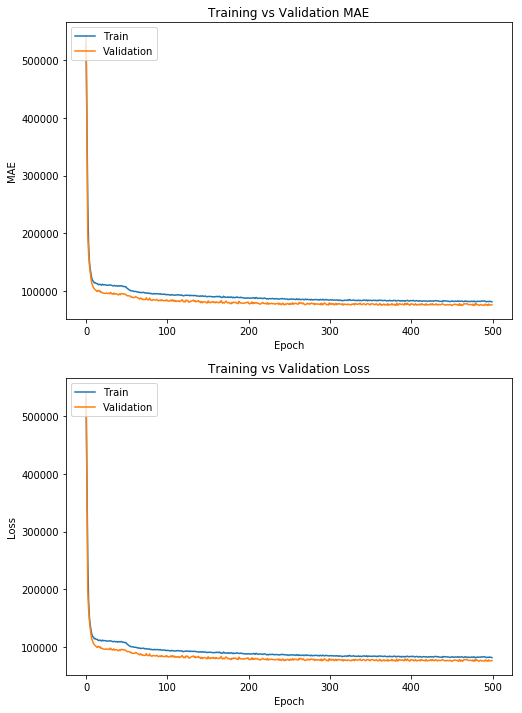

In [27]:
plot_hist(history.history, xsize=8, ysize=12)